In [5]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from itertools import product, chain
import importlib

import trainer, data, models

In [70]:
importlib.reload(trainer)
importlib.reload(data)
importlib.reload(models)

<module 'models' from '/Users/ralph/projects/d2dl/models.py'>

In [71]:
kaggle_housing_dataset = data.kaggle_housing()

In [74]:
kaggle_housing_dataset.train[0][0].dtype

torch.float32

In [77]:
provider = lambda hyperparams: trainer.Trainer(
    model=models.LinearRegression(num_outputs=1),
    dataset=kaggle_housing_dataset,
    loss=nn.MSELoss,
    opt=torch.optim.SGD,
    hyperparameters=hyperparams
)

In [78]:
model_trainer = provider(trainer.Hyperparameters(
    opt=dict(
        lr = 1e-3
    ),
    general=dict(
        num_epochs = 1,
        batch_size = 256
    )
))

In [79]:
train_result = model_trainer.train(10)

/Users/ralph/.venvs/d2dl/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/ralph/.venvs/d2dl/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/ralph/.venvs/d2dl/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they hav

pred_y type torch.float32
train_y type torch.float32
loss type torch.float32
pred_y type torch.float32
train_y type torch.float32
loss type torch.float32


<Axes: >

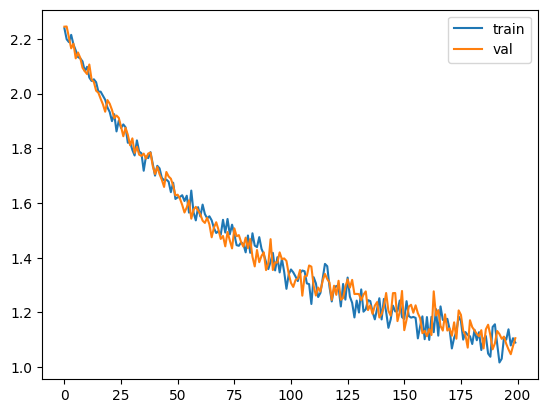

In [30]:
train_result.plot()

In [31]:
_, val_dataloader = fashion_mnist_dataset.get_dataloaders(256)

In [32]:
results = []
for images, true_labels in val_dataloader:
    scores = trainer.model(images)
    pred_labels = scores.argmax(dim=1)
    results.append(pred_labels.eq(true_labels))

In [33]:
true_labels

tensor([9, 2, 3, 6, 2, 6, 2, 3, 2, 8, 6, 1, 3, 2, 8, 6])

In [34]:
pred_labels

tensor([9, 2, 3, 4, 2, 4, 2, 3, 4, 8, 3, 1, 3, 2, 8, 0])

In [35]:
results[-1]

tensor([ True,  True,  True, False,  True, False,  True,  True, False,  True,
        False,  True,  True,  True,  True, False])

In [36]:
all_results = torch.cat(results)

In [37]:
all_results.sum() / all_results.shape[0]

tensor(0.6723)